In [ ]:
# @title Access Key for Dataset {"run":"auto","vertical-output":true,"display-mode":"form"}
ACCESS_KEY = "AISTETIC" # @param {"type":"string"}


# **<span color="purple">TO DO: Hypothesis Tests</span>**


---


RQ1: Does a patient with `diabetes and an atrial rate of higher than 70 and a QRS duration of lower than 90 have lead to an abnormal ecg` diagnoses by medical professionals?


---


RQ2: Do former smokers with a `PR interval lower than 60 have a high incidence of diabetes`?





# **<span color="purple">Imports</span>**

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime
from matplotlib import ticker
from scipy.stats import ttest_ind
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder,
                                   OrdinalEncoder, RobustScaler)
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# **<span color="purple">Configurations</span>**

In [ ]:
plt.style.use('seaborn-v0_8-deep')
plt.rcParams["font.family"] = "STIXGeneral"

def set_global_determinism(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


DELIMITER = f'\n\n{"*" * 100}\n\n'
SEED = 42
FOLDS = 5

set_global_determinism(SEED)

In [ ]:
def generate_fernet_key(key):
    import base64
    import hashlib


    return base64.urlsafe_b64encode(hashlib.sha256(key.encode()).digest())


def decrypt_link(encrypted_link, key):
    from cryptography.fernet import Fernet


    fernet_key = generate_fernet_key(key)
    cipher_suite = Fernet(fernet_key)
    decrypted_link = cipher_suite.decrypt(encrypted_link.encode())
    return decrypted_link.decode()


DS_LINK = "gAAAAABmyMWlt2tzS49oxCJv7Bvx_8c_KxZTSVrWVV1pPEfJ1YR3Fzeb6kkWb3ogTHOrggz-Xlksg1X_qikTKzaJjWCmuoIZaO7fIDaJchBba5FDwjJ2Imnf0_ZI6se_VvCiP8R8w4nntBIZKrNuf0cKqhIsekgGV_ZiP9wUJ1yD7YDz9d-UFb9C6bgVYvdtlj-C1Un4qEXm"
DS_LINK = decrypt_link(DS_LINK, ACCESS_KEY)

# **<span color="purple">EDA</span>**

In [ ]:
df = pd.read_csv(DS_LINK, na_values=['', ' ', 'NA', 'Invalid', 'Failed'], keep_default_na=False)

print(df.shape)
print(DELIMITER)
print(df.info())
print(DELIMITER)

# df = df.drop_duplicates(subset='MRN_ANON_ID')

nuisance_cols = [0, 1]
df.drop(df.columns[nuisance_cols], axis=1, inplace=True)
df.head()

(4466, 30)


****************************************************************************************************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4466 entries, 0 to 4465
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MRN_ANON_ID              4466 non-null   object 
 1   ORDER_PROC_ID            4466 non-null   object 
 2   SEX                      4466 non-null   object 
 3   WEIGHT                   4437 non-null   float64
 4   DIABETES                 4466 non-null   object 
 5   SMOKE                    4466 non-null   object 
 6   VENTRICULAR RATE         4466 non-null   int64  
 7   ATRIAL RATE              4466 non-null   int64  
 8   P-R INTERVAL             4451 non-null   float64
 9   QRS DURATION             4466 non-null   int64  
 10  Q-T INTERVAL             4466 non-null   int64  
 11  QTC CALCULATION (BEZET)  4466 non-null   int64  
 12  P AXIS          

,SEX,WEIGHT,DIABETES,SMOKE,VENTRICULAR RATE,ATRIAL RATE,P-R INTERVAL,QRS DURATION,Q-T INTERVAL,QTC CALCULATION (BEZET),...,Diagnosis Line_5,Diagnosis Line_6,Diagnosis Line_7,Diagnosis Line_8,Diagnosis Line_9,Diagnosis Line_10,Diagnosis Line_11,Diagnosis Line_12,Diagnosis Line_13,Diagnosis Line_14
0,Male,204.59,Y,Former,74,74,266.0,88,438,486,...,VENTRICULAR RATE HAS DECREASED BY 3 BPM,"WHEN COMPARED WITH ECG OF 19-APR-2024 20:17,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Male,204.59,Y,Former,88,88,240.0,82,348,421,...,SINUS RHYTHM WITH FIRST DEGREE A-V BLOCK WITH ...,T WAVE INVERSION LESS EVIDENT IN LATERAL LEADS,"WHEN COMPARED WITH ECG OF 24-APR-2024 05:53,",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Male,204.59,Y,Former,77,77,232.0,80,396,448,...,SINUS RHYTHM WITH FIRST DEGREE A-V BLOCK WITH ...,"WHEN COMPARED WITH ECG OF 25-APR-2024 06:22,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Male,330.00,Y,Never,100,100,154.0,74,370,477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,162.48,N,Never,58,58,135.0,92,410,403,...,Sinus bradycardia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


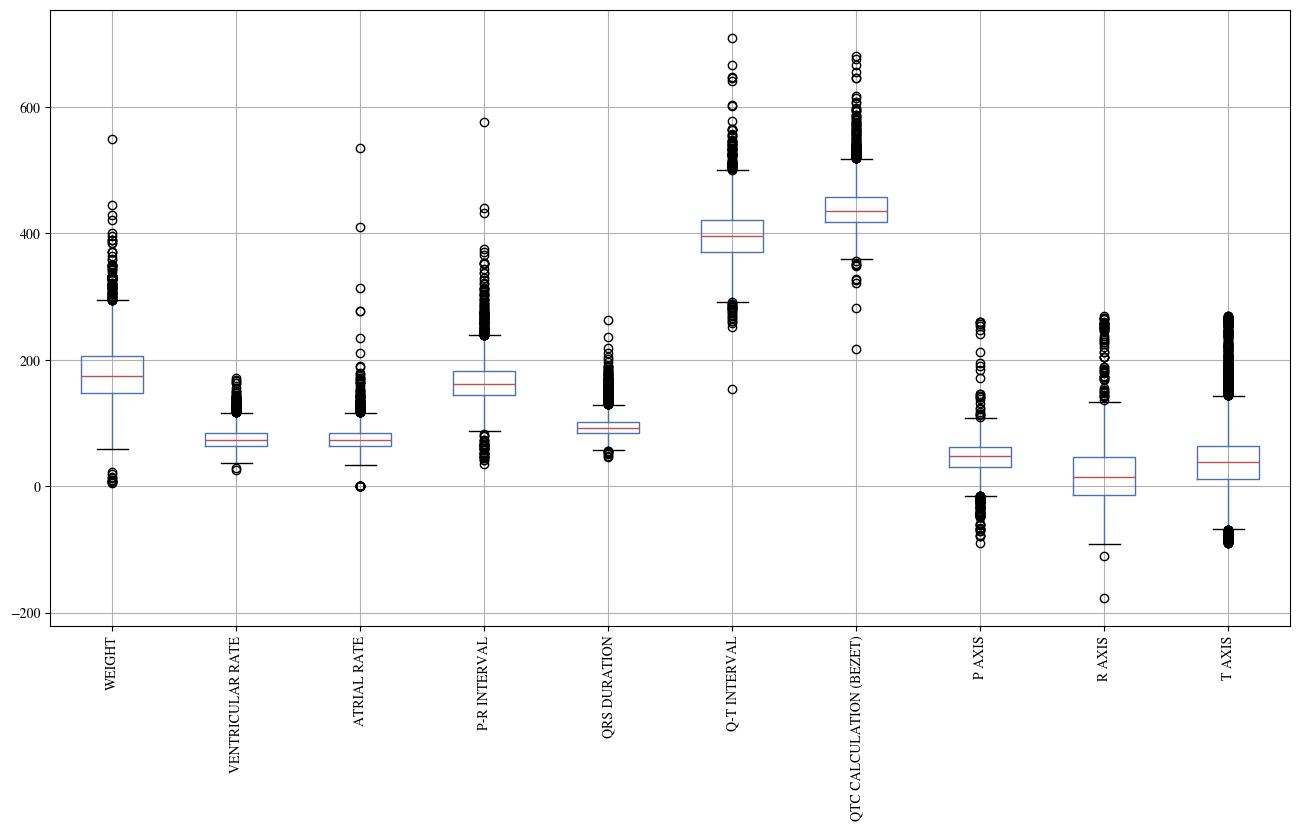

In [ ]:
df.boxplot(figsize=(16,8))
plt.xticks(rotation=90)
plt.show()

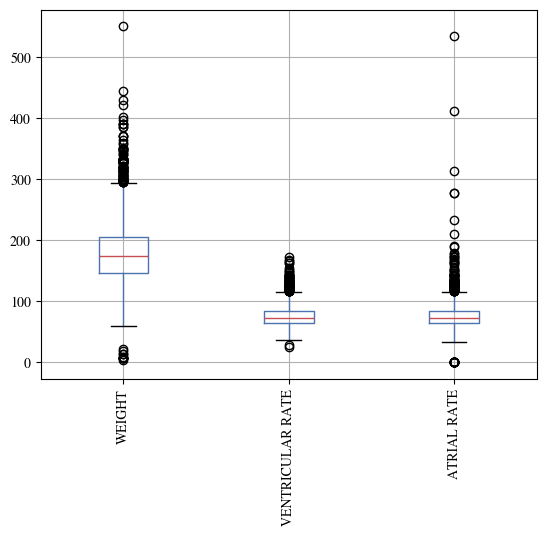

In [ ]:
df[['WEIGHT', 'VENTRICULAR RATE', 'ATRIAL RATE']].boxplot()
plt.xticks(rotation=90)
plt.show()

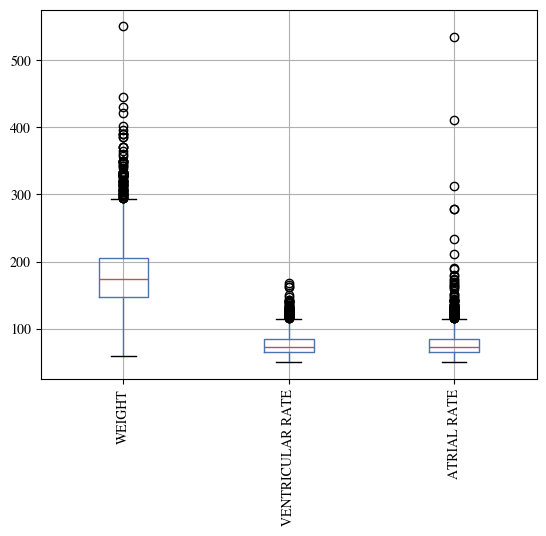

In [ ]:
OUTLIER_THRESHOLD = 50

df[df['WEIGHT'] < 50] = np.nan
df[df['VENTRICULAR RATE'] < OUTLIER_THRESHOLD] = np.nan
df[df['ATRIAL RATE'] < OUTLIER_THRESHOLD] = np.nan

df[['WEIGHT', 'VENTRICULAR RATE', 'ATRIAL RATE']].boxplot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
def create_diagnosis_col(df):
    # Consolidate diagnosis columns
    diagnosis_cols = df.columns[13:]
    df['DIAGNOSIS'] = df[diagnosis_cols].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)
    df.drop(diagnosis_cols, axis=1, inplace=True)

    target_map = {
        'abnormal ecg': 1,
        'borderline ecg': 1,
        'normal ecg': 0
    }

    def encode_target(diagnosis):
        for key, value in target_map.items():
            if key in diagnosis.lower():  # case-insensitive matching
                return value
        return None  # Return None if no match is found

    df['DIAGNOSIS'] = df['DIAGNOSIS'].apply(encode_target)

    return df


def drop_missing_target_rows(df):
    """
    WARNING: This is a baseline and naive method. A better method
    (implemented in the future) would be to perform semi-supervised learning
    """
    df.dropna(subset=['DIAGNOSIS'], inplace=True)

    return df


def correct_smoker_col(df):
    # Smoker values = {Former, Never, Never Assessed, Some Days, Unknown,
    #                  (Smoker, Current Status Unknown), Every Day, Light Smoker,
    #                  Passive Smoke Exposure - Never Smoker, Heavy Smoker}
    # |Smoker| = 10: too much values and some label values are redundant

    categories = {
        'never': 0,
        'never assessed': 1,
        'unknown': 1,
        'former': 2,
        'smoker, current status unknown': 3,
        'light smoker': 3,
        'some days': 3,
        'passive smoke exposure - never smoker': 3,
        'every day': 4,
        'heavy smoker': 4
    }

    def encode_smoker(smoker):
        for key, value in categories.items():
            if key in smoker.lower():  # case-insensitive matching
                return value
        return None  # Return None if no match is found

    df['SMOKE'] = df['SMOKE'].apply(encode_smoker).astype('int64')

    return df

In [ ]:
target_transformer = FunctionTransformer(create_diagnosis_col)
missing_transformer = FunctionTransformer(drop_missing_target_rows)

target_pipeline = Pipeline([
    ('target', target_transformer),
    ('missing', missing_transformer),
])

df = target_pipeline.fit_transform(df)
print(df.info())
print(DELIMITER)
df

<class 'pandas.core.frame.DataFrame'>
Index: 3885 entries, 0 to 4465
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEX                      3885 non-null   object 
 1   WEIGHT                   3868 non-null   float64
 2   DIABETES                 3885 non-null   object 
 3   SMOKE                    3885 non-null   object 
 4   VENTRICULAR RATE         3885 non-null   float64
 5   ATRIAL RATE              3885 non-null   float64
 6   P-R INTERVAL             3872 non-null   float64
 7   QRS DURATION             3885 non-null   float64
 8   Q-T INTERVAL             3885 non-null   float64
 9   QTC CALCULATION (BEZET)  3885 non-null   float64
 10  P AXIS                   3871 non-null   float64
 11  R AXIS                   3885 non-null   float64
 12  T AXIS                   3882 non-null   float64
 13  DIAGNOSIS                3885 non-null   float64
dtypes: float64(11), object(3)
mem

,SEX,WEIGHT,DIABETES,SMOKE,VENTRICULAR RATE,ATRIAL RATE,P-R INTERVAL,QRS DURATION,Q-T INTERVAL,QTC CALCULATION (BEZET),P AXIS,R AXIS,T AXIS,DIAGNOSIS
0,Male,204.59,Y,Former,74.0,74.0,266.0,88.0,438.0,486.0,37.0,-28.0,27.0,1.0
1,Male,204.59,Y,Former,88.0,88.0,240.0,82.0,348.0,421.0,66.0,-11.0,69.0,1.0
2,Male,204.59,Y,Former,77.0,77.0,232.0,80.0,396.0,448.0,32.0,-10.0,61.0,1.0
3,Male,330.00,Y,Never,100.0,100.0,154.0,74.0,370.0,477.0,67.0,64.0,69.0,0.0
4,Male,162.48,N,Never,58.0,58.0,135.0,92.0,410.0,403.0,45.0,28.0,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4460,Female,119.00,N,Never,75.0,62.0,172.0,146.0,432.0,482.0,49.0,-21.0,118.0,1.0
4461,Female,119.00,N,Never,71.0,71.0,178.0,144.0,454.0,493.0,57.0,-5.0,84.0,1.0
4463,Female,248.00,Y,Never,62.0,62.0,212.0,94.0,438.0,444.0,41.0,12.0,6.0,1.0
4464,Female,120.00,N,Former,72.0,72.0,182.0,100.0,400.0,438.0,87.0,-22.0,69.0,0.0


In [ ]:
X = df.drop(['DIAGNOSIS'], axis=1)
y = df['DIAGNOSIS']

In [ ]:
smoker_pipeline = make_pipeline(
    FunctionTransformer(correct_smoker_col),
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(),
)

heavytail_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    FunctionTransformer(np.log1p),
)

onehot_pipeline = make_pipeline(
    OneHotEncoder(sparse_output=False, dtype='int64'),
    SimpleImputer(strategy='most_frequent'),
)

ordinal_pipeline = make_pipeline(
    OrdinalEncoder(dtype='int64'),
    SimpleImputer(strategy='most_frequent'),
)

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
)

preprocessing = ColumnTransformer([
    ('smoke', smoker_pipeline, ['SMOKE']),
    ('heavytail', heavytail_pipeline, ['P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)']),
    ('onehot_encoder', onehot_pipeline, ['SEX']),
    ('ordinal_encoder', ordinal_pipeline, ['DIABETES']),
], remainder=numerical_pipeline)

X = preprocessing.fit_transform(X)

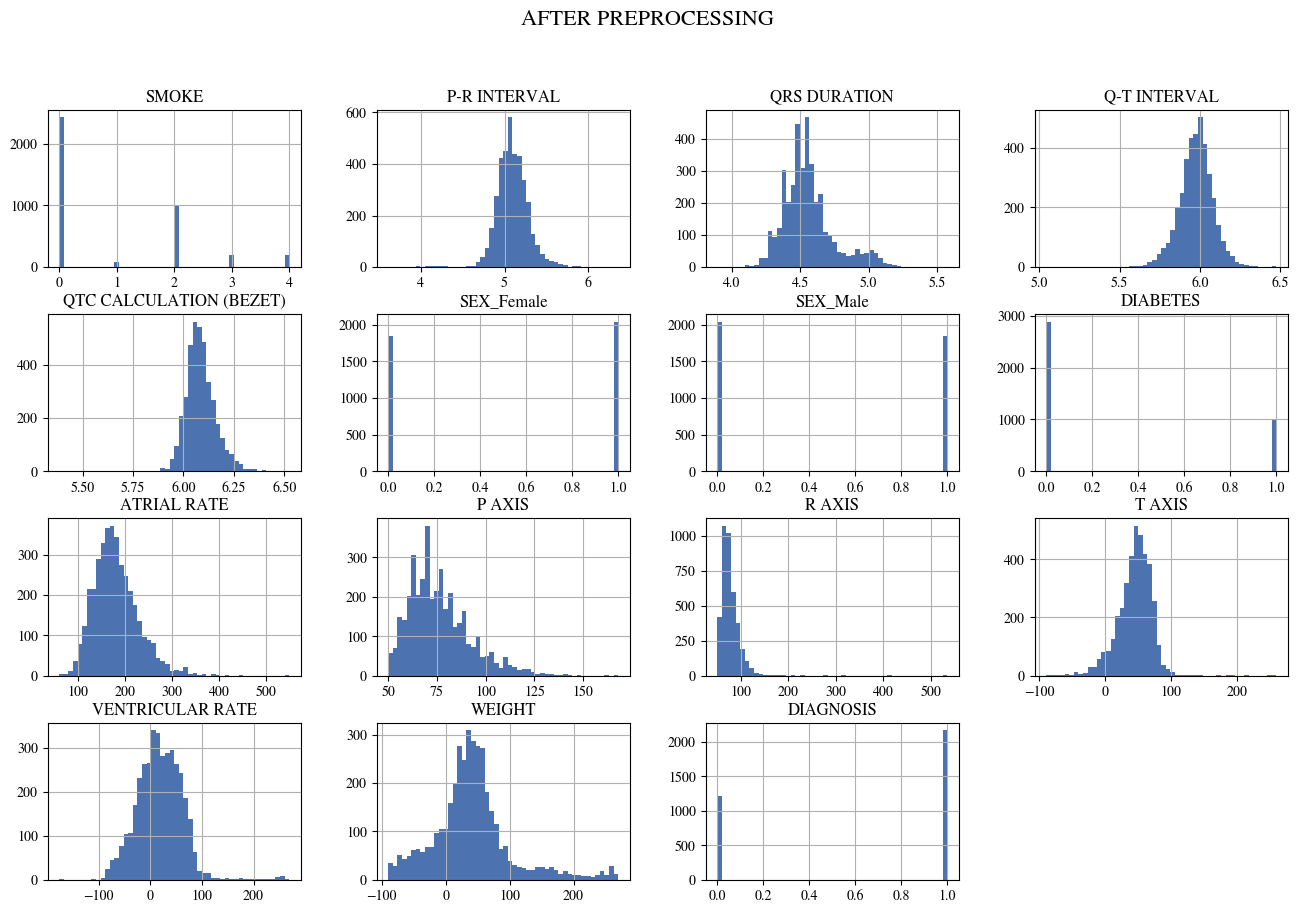

In [ ]:
transformed_column_names = (
    ['SMOKE'] +
    ['P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)'] +
    preprocessing.named_transformers_['onehot_encoder'].get_feature_names_out(['SEX']).tolist() +
    ['DIABETES'] +
    df.columns.difference(['SMOKE', 'P-R INTERVAL', 'QRS DURATION', 'Q-T INTERVAL', 'QTC CALCULATION (BEZET)', 'SEX', 'DIABETES', 'DIAGNOSIS']).tolist()
)

X = pd.DataFrame(X, columns=transformed_column_names)
X['DIAGNOSIS'] = df['DIAGNOSIS']
X.hist(bins=50, figsize=(16, 10))
plt.suptitle('AFTER PREPROCESSING', fontsize=16)
plt.show()

# **<span color="purple">Multiple (Hypothesis) Testing using the Bonferroni Method</span>**

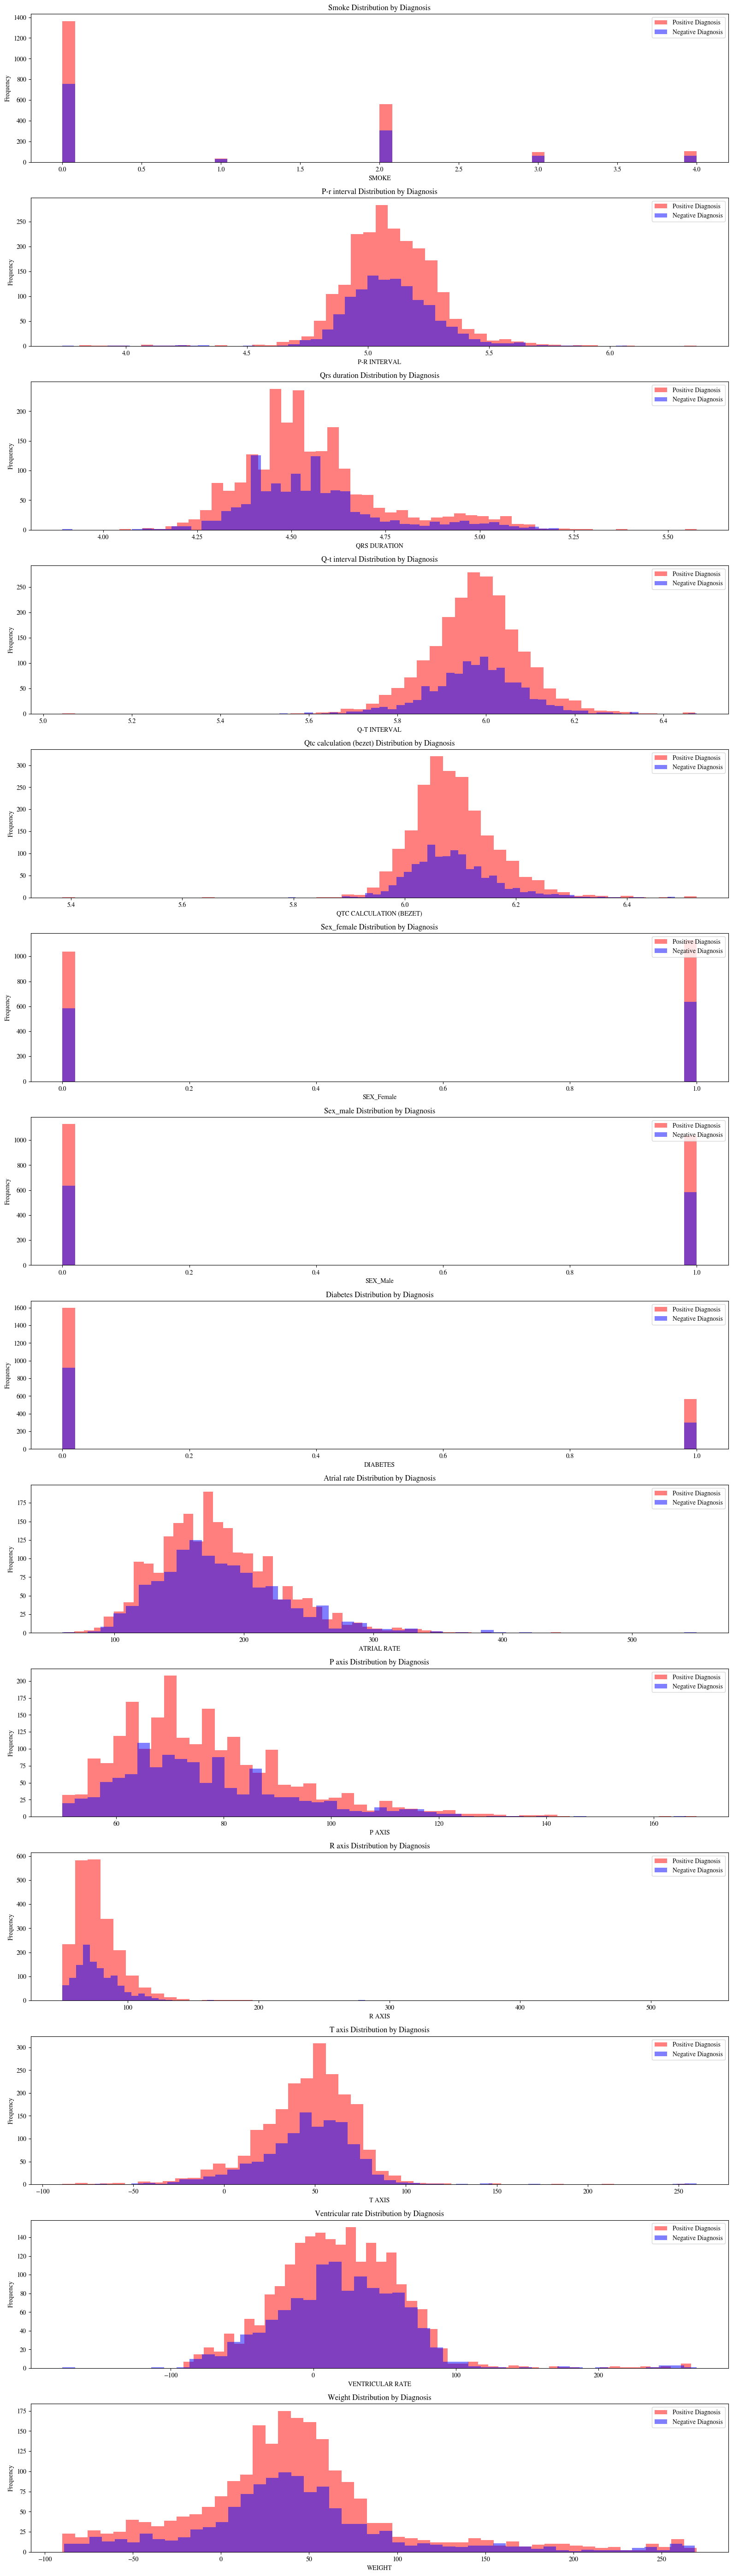

In [ ]:
X_pos = X[X['DIAGNOSIS'] == 1]
X_neg = X[X['DIAGNOSIS'] == 0]

num_columns = len(X.columns) - 1
fig, axes = plt.subplots(num_columns, 1, figsize=(16, num_columns * 4))

for i, column in enumerate(X.columns):
    if column == 'DIAGNOSIS':
        continue

    ax = axes[i] if num_columns > 1 else axes

    ax.hist(X_pos[column], bins=50, color='red', alpha=0.5, label='Positive Diagnosis')
    ax.hist(X_neg[column], bins=50, color='blue', alpha=0.5, label='Negative Diagnosis')
    ax.set_title(f"{column.capitalize()} Distribution by Diagnosis")
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
columns_to_test = X.columns.difference(['SEX_Female', 'DIAGNOSIS'])
num_hypothesis = len(columns_to_test)

SIG_LEVEL = 0.05
BONFERRONI_SIG_LEVEL = round(SIG_LEVEL / num_hypothesis, 4)

p_vals = []
for column in columns_to_test:
    t_stat, p_val = ttest_ind(X_pos[column], X_neg[column])
    p_vals.append(p_val)

print("p-values:", p_vals)
print(f"Significance Level (with Bonferroni Correction): {BONFERRONI_SIG_LEVEL}")

p-values: [0.11098525810707985, 0.3023294446544339, 0.9491849019054266, 0.5317788824617884, 0.6922734398122337, 0.5456376591981007, 0.5300297572659822, 0.8547424515175515, 0.9776253115551579, 0.6492556595268351, 0.5078190959943161, 0.6236027248219905, 0.31496306346923403]
Significance Level (with Bonferroni Correction): 0.0038


In [ ]:
res_hypothesis = [True if p_val < BONFERRONI_SIG_LEVEL else False for p_val in p_vals]
signs_hypothesis = ['<' if res else '>' for res in res_hypothesis]

df = pd.DataFrame({'Hypothesis': columns_to_test,
                   'p-value': p_vals,
                   '': signs_hypothesis,
                   'Significance Level (Bonferroni Correction)': BONFERRONI_SIG_LEVEL,
                   'Reject H0?': res_hypothesis,
                  })

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

,Hypothesis,p-value,,Significance Level (Bonferroni Correction),Reject H0?
0,ATRIAL RATE,0.110985,>,0.003800,False
1,DIABETES,0.302329,>,0.003800,False
2,P AXIS,0.949185,>,0.003800,False
3,P-R INTERVAL,0.531779,>,0.003800,False
4,Q-T INTERVAL,0.692273,>,0.003800,False
5,QRS DURATION,0.545638,>,0.003800,False
6,QTC CALCULATION (BEZET),0.530030,>,0.003800,False
7,R AXIS,0.854742,>,0.003800,False
8,SEX_Male,0.977625,>,0.003800,False
9,SMOKE,0.649256,>,0.003800,False


# **<span color="purple">Exclude Nominal Features, i.e., only test numerical features</span>**

In [ ]:
columns_to_test = X.columns.difference(['SMOKE', 'SEX_Female', 'SEX_Male', 'DIAGNOSIS', 'DIABETES'])
num_hypothesis = len(columns_to_test)

SIG_LEVEL = 0.05
BONFERRONI_SIG_LEVEL = round(SIG_LEVEL / num_hypothesis, 4)

p_vals = []
for column in columns_to_test:
    t_stat, p_val = ttest_ind(X_pos[column], X_neg[column])
    p_vals.append(p_val)

print("p-values:", p_vals)
print(f"Significance Level (with Bonferroni Correction): {BONFERRONI_SIG_LEVEL}")

p-values: [0.11098525810707985, 0.9491849019054266, 0.5317788824617884, 0.6922734398122337, 0.5456376591981007, 0.5300297572659822, 0.8547424515175515, 0.5078190959943161, 0.6236027248219905, 0.31496306346923403]
Significance Level (with Bonferroni Correction): 0.005


In [ ]:
res_hypothesis = [True if p_val < BONFERRONI_SIG_LEVEL else False for p_val in p_vals]
signs_hypothesis = ['<' if res else '>' for res in res_hypothesis]

df = pd.DataFrame({'Hypothesis': columns_to_test,
                   'p-value': p_vals,
                   '': signs_hypothesis,
                   'Significance Level (Bonferroni Correction)': BONFERRONI_SIG_LEVEL,
                   'Reject H0?': res_hypothesis,
                  })

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

,Hypothesis,p-value,,Significance Level (Bonferroni Correction),Reject H0?
0,ATRIAL RATE,0.110985,>,0.005000,False
1,P AXIS,0.949185,>,0.005000,False
2,P-R INTERVAL,0.531779,>,0.005000,False
3,Q-T INTERVAL,0.692273,>,0.005000,False
4,QRS DURATION,0.545638,>,0.005000,False
5,QTC CALCULATION (BEZET),0.530030,>,0.005000,False
6,R AXIS,0.854742,>,0.005000,False
7,T AXIS,0.507819,>,0.005000,False
8,VENTRICULAR RATE,0.623603,>,0.005000,False
9,WEIGHT,0.314963,>,0.005000,False
